# Adamic-Adar

The Adamic-Adar (AA) heuristic (<span style="font-variant:small-caps;">Adamic and Adar (2003)</span>) is a local heuristic in the context of traditional link prediction methods. Local heuristics use node similarity scores to predict the likelihood of a link.

Let $x$ and $y$ be the source and the target node between which to predict a link and let $\Gamma\left(x\right)$ be the set of $x$'s neighbors. Then the Adamic-Adar heuristic is calculated as 

$$f_{\text{AA}}\left(x,y\right)=\sum_{z\in\Gamma\left(x\right)\cap\Gamma\left(y\right)}\frac{1}{\text{log}\lvert\Gamma\left(z\right)\rvert},$$

where the weight of common neighbors is considered. A high-degree common neighbor $z$ is weighted less because it is downweighted by the reciprocal of $\text{log}\lvert\Gamma\left(z\right)\rvert$.

The Adamic-Adar heuristic is meant to serve as a baseline for later comparison with the three GNNs. This heuristic does not take node features into account.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.sparse as sp

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

import ipynb
from ipynb.fs.defs.helpers import *
import pickle

import json
import os
import time

import networkx as nx

from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

## Define helper functions

In [2]:
def get_roc_score(edges_pos, edges_neg, score_matrix):
    # Store positive edge predictions, actual values
    preds_pos = []
    pos = []
    for edge in edges_pos:
        preds_pos.append(score_matrix[edge[0], edge[1]]) # predicted score
        pos.append(adj[edge[0], edge[1]]) # actual value (1 for positive)
        
    # Store negative edge predictions, actual values
    preds_neg = []
    neg = []
    for edge in edges_neg:
        preds_neg.append(score_matrix[edge[0], edge[1]]) # predicted score
        neg.append(adj[edge[0], edge[1]]) # actual value (0 for negative)
        
    # Calculate score
    preds_all = np.hstack([preds_pos, preds_neg])
    labels_all = np.hstack([np.ones(len(preds_pos)), np.zeros(len(preds_neg))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)
    return roc_score, ap_score

In [3]:
def mean(dict_values):
    """
    Get mean of dictionary values.
    """
    return np.mean(np.array(list(dict_values)))

In [4]:
def std(dict_values):
    """
    Get standard deviation of dictionary values.
    """
    return np.std(np.array(list(dict_values)))

## Creation of graph and adjacency matrix

Link prediction in the context of local heuristics can be performed using the [networkx implementation](https://networkx.org/documentation/stable/reference/algorithms/link_prediction.html) of the most important local heuristics, such as [`resource_allocation_index`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.resource_allocation_index.html#networkx.algorithms.link_prediction.resource_allocation_index), [`jaccard_coefficient`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.jaccard_coefficient.html#networkx.algorithms.link_prediction.jaccard_coefficient), [`adamic_adar_index`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.adamic_adar_index.html#networkx.algorithms.link_prediction.adamic_adar_index) and [`preferential_attachment`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.preferential_attachment.html#networkx.algorithms.link_prediction.preferential_attachment). Note, however, that the implementation provided for common neighbors, [`cn_soundarajan_hopcroft`](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.link_prediction.cn_soundarajan_hopcroft.html#networkx.algorithms.link_prediction.cn_soundarajan_hopcroft), does not correspond to our common neighbor heuristic. 

These implemented local heuristics take a graph - with its nodes and links - as input and calculate the respective score for all other currently non-existing links, i.e., all other possible links, of this graph. In our case, this means that we pass a training graph to the function `adamic_adar_index`, containing all nodes of the original graph but only a fraction of 0.6 of links of the original graph. We then obtain the Adamic-Adar score for all other currently non-existing links in the training graph and therefore also for the validation and test edges.

As preliminary work, we first need to load the links of our original graph, create a networkx graph from them using `nx.Graph()` and calculate the adjacency matrix of this networkx graph, which comes in SciPy sparse format.

In [5]:
# read in all_links
with open('./all_links.txt', 'r') as f:
    all_links = json.loads(f.read())

In [6]:
# create graph and adjacency matrix
g = nx.Graph(all_links)
adj = nx.adjacency_matrix(g)

We now plot the graph to get a better impression of it.

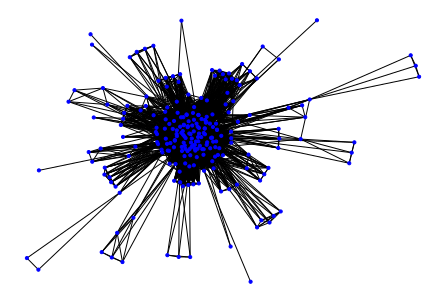

In [7]:
# draw graph
np.random.seed(1234)
plt.figure(figsize=(6,4))
graph=nx.draw(g, with_labels=False, node_size=10, node_color='b')

It is evident that one group of HCPs has many connections to other HCPs, while another group of HCPs has only very few connections to other HCPs.

## Training loop

In our training loop, we use the following train-validation-test split: The training set contains a fraction of 0.6 of all 5821 links of our original graph, the validation set contains a fraction of 0.1 of all 5821 links of our original graph and the test set contains a fraction of 0.3 of all 5821 links of our original graph.

The 5821 links referred to above are links that actually exist and can therefore also be called *positive edges*. Links that do not actually exist in a graph are called *negative edges*.

In addition to the positive training, validation and test edges - called `train_edges`, `val_edges` and `test_edges` below, an equal number of negative training, validation and test edges - called `train_edges_false`, `val_edges_false` and `test_edges_false` below - are also extracted. The reason why negative edges are also extracted is that we want to determine not only how reliably the presence of a positive edge is predicted, but also how reliably the absence of a negative edge is predicted.  

Note that `nx.adamic_adar_index(g_train)` only calculates the Adamic-Adar index for all edges that are not part of the graph with the positive training edges. For positive edges in the training set, the Adamic-Adar adjacency matrix `aa_matrix` always contains a value of 0. Therefore, it is sensible to calculate scores such as the AUC or AP for the validation and test set, but not for the training set.

We perform 10 runs with different train-validation-test splits, where the respective fractions of 0.6, 0.1 and 0.3 of course always remain unchanged.

The training loop calculates the validation AUCs and APs, test AUCs and APs in the 10 runs as well as the mean validation AUC and AP, mean test AUC and AP, standard deviation of validation AUCs and APs, standard deviation of test AUCs and APs over the 10 runs. We save all results in `aa_results`.

## Hyperparameter tuning

There are no hyperparameters to tune for the Adamic-Adar heuristic.

In [8]:
# Create results folder
route0 = "./results"

if not os.path.exists(route0):
    os.mkdir(route0)

In [9]:
start_time = time.time()

aa_results = pd.DataFrame(columns = ['val_auc', 'val_ap', 'test_auc', 'test_ap', 'mean_val_auc', 'mean_val_ap', 'mean_test_auc',
                                     'mean_test_ap', 'std_val_auc', 'std_val_ap', 'std_test_auc', 'std_test_ap'])

seeds = [12345, 23456, 34567, 45678, 56789, 54321, 65432, 76543, 87654, 98765]

val_auc_dict = dict()
val_ap_dict = dict()
test_auc_dict = dict()
test_ap_dict = dict()

for i, seed in enumerate(seeds):
    
    print(f'==================================================\nRun {i+1} with seed {seed}:\n==================================================')
    
    np.random.seed(seed)
    
    # Perform train-validation-test split
    adj_train, train_edges, train_edges_false, val_edges, val_edges_false, \
        test_edges, test_edges_false = mask_test_edges(adj, test_frac=.3, val_frac=.1)
    g_train = nx.from_scipy_sparse_matrix(adj_train) 
    
    # Compute Adamic-Adar indices from g_train
    aa_matrix = np.zeros(adj.shape)
    for u, v, p in nx.adamic_adar_index(g_train): 
        aa_matrix[u][v] = p
        aa_matrix[v][u] = p 
    
    # Normalize array
    aa_matrix = aa_matrix / aa_matrix.max()
    
    # Calculate AUC and AP for validation and test set
    val_auc, val_ap = get_roc_score(val_edges, val_edges_false, aa_matrix)
    test_auc, test_ap = get_roc_score(test_edges, test_edges_false, aa_matrix)
    
    print(f'Validation AUC: {val_auc:.4f}, Validation AP: {val_ap:.4f}, Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')

    val_auc_dict.update({f"{i+1}": val_auc})
    val_ap_dict.update({f"{i+1}": val_ap})    
    test_auc_dict.update({f"{i+1}": test_auc})
    test_ap_dict.update({f"{i+1}": test_ap})   
    
data_concat = [{'val_auc': val_auc_dict, 'val_ap': val_ap_dict, 'test_auc': test_auc_dict, 'test_ap': test_ap_dict, 
                'mean_val_auc': mean(val_auc_dict.values()), 'mean_val_ap': mean(val_ap_dict.values()), 
                'mean_test_auc': mean(test_auc_dict.values()), 'mean_test_ap': mean(test_ap_dict.values()),
                'std_val_auc': std(val_auc_dict.values()), 'std_val_ap': std(val_ap_dict.values()),
                'std_test_auc': std(test_auc_dict.values()), 'std_test_ap': std(test_ap_dict.values())}]
df_concat = pd.DataFrame(data_concat)
aa_results = pd.concat([aa_results, df_concat], ignore_index=True)
    
print('====================================================================================================',
      '\n====================================================================================================', 
      '\n====================================================================================================')

print("saving file corresponding to aa_results.pkl")
aa_results.to_pickle(f"{route0}/aa_results.pkl")

end_time = time.time()
duration = end_time - start_time
print(f"{int(np.floor(duration/3600))} hours {(duration-3600*np.floor(duration/3600))/60:.4} minutes")

Run 1 with seed 12345:
Validation AUC: 0.9652, Validation AP: 0.9662, Test AUC: 0.9569, Test AP: 0.9587
Run 2 with seed 23456:
Validation AUC: 0.9583, Validation AP: 0.9558, Test AUC: 0.9554, Test AP: 0.9548
Run 3 with seed 34567:
Validation AUC: 0.9579, Validation AP: 0.9580, Test AUC: 0.9599, Test AP: 0.9596
Run 4 with seed 45678:
Validation AUC: 0.9530, Validation AP: 0.9544, Test AUC: 0.9566, Test AP: 0.9567
Run 5 with seed 56789:
Validation AUC: 0.9433, Validation AP: 0.9453, Test AUC: 0.9493, Test AP: 0.9517
Run 6 with seed 54321:
Validation AUC: 0.9601, Validation AP: 0.9602, Test AUC: 0.9606, Test AP: 0.9600
Run 7 with seed 65432:
Validation AUC: 0.9507, Validation AP: 0.9526, Test AUC: 0.9595, Test AP: 0.9598
Run 8 with seed 76543:
Validation AUC: 0.9660, Validation AP: 0.9653, Test AUC: 0.9520, Test AP: 0.9536
Run 9 with seed 87654:
Validation AUC: 0.9640, Validation AP: 0.9637, Test AUC: 0.9579, Test AP: 0.9582
Run 10 with seed 98765:
Validation AUC: 0.9516, Validation AP: 0

In [10]:
# Look at results
aa_results = pd.read_pickle(f"{route0}/aa_results.pkl") 
aa_results

,val_auc,val_ap,test_auc,test_ap,mean_val_auc,mean_val_ap,mean_test_auc,mean_test_ap,std_val_auc,std_val_ap,std_test_auc,std_test_ap
0,"{'1': 0.9652106139511815, '2': 0.9582993823880...","{'1': 0.966201800319228, '2': 0.95580435093320...","{'1': 0.9569178905408403, '2': 0.9554488150956...","{'1': 0.9586502554567546, '2': 0.9548219830069...",0.957007,0.957581,0.956664,0.957315,0.006958,0.006151,0.00342,0.002836


We can see that the mean AUC and AP values are nearly the same in the validation and test set. This shows us that the performance observable in the test set is reliable since it is corroborated by the performance in the validation set.